# Continuous time recurrent neural network - more advanced topics

john serences (jserences@ucsd.edu) 06.2024

* In the `basics` tutorial we covered how to create and train a continuous time RNN. While some biological 'realism' was built in (e.g. activation function, pre/post activation noise), we did not place any constraints on the weight matrices, the degree to which units are connected, or the sign of the connections (i.e. excitatory vs inhibitory synapses). For example, in visual cortex we having excitatory neurons (pyramidal cells) and we have inhibitory interneurons. Generally speaking these neurons serve a fixed function (Dale's principle), they exist in more-or-less known ratios, and they have different temporal properties. Implementing some of these constraints can dramaticallly change how an RNN solves a given problem, and also allows us to ask more targeted questions about the role of different cell types in information processing.
  
* Dale's principle: unit j is excitatory if all of its projections on other units are zero or excitatory, i.e.,
if $W^{hid}_{ij} > 0$ for all $i$ and inhibitory if $W^{hid}_{ij} < 0$ for all $i$ 



### imports

In [51]:
# minimal imports - can import sub modules to make code cleaner, but
# keeping this simple for now
import numpy as np
import matplotlib.pyplot as plt
import torch

# import class to make model inputs (defines different tasks, and can add other tasks easily using this framework)
from tasks import ctTASKS

# import class to make model, make hidden layer, and loss function
from ct_rnn import *
from h_layer import *

# load the autoreload extension - don't need for tutorial but good if you ever modify the classes used in the tutorial 
# autoreload will update if you make changes to the ctTASKS class
%load_ext autoreload
%autoreload 2

# check for available devices 
# (this works for M1/M2 macs, but you can check for 
# other devices as well using torch.backends)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    # set the device to default 
    torch.set_default_device(mps_device)
else:
   print ("MPS device not found. Using cpu")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define network params, task params, and build the network

In [ ]:
#--------------------------------
# task params
#--------------------------------
task_type = 'go-nogo' # task type (go-nogo, mante, xor)
T = 100          # timesteps in each trial
stim_on = 50     # timestep of stimulus onset
stim_dur = 25    # stim duration
n_trials = 64    # number of trials in each training batch
acc_amp_thresh =[0.8,0.2]  # to determine acc of model output: > acc_amp_thresh[0] is classified as a 'go' trial, < acc_amp_thresh[1] is 'nogo'

# init dict of task related params 
settings = {'task' : task_type, 'T' : T, 'stim_on' : stim_on, 'stim_dur' : stim_dur, 'n_trials' : n_trials,
           'acc_amp_thresh' : acc_amp_thresh}

# create the task object
task = ctTASKS(settings)


### delayed match to sample...

In [ ]:
#--------------------------------
# task params
#--------------------------------
task_type = 'dmts'    # task type (go-nogo, mante, dmts)
T = 300          # timesteps in each trial
stim_on = 50     # timestep of stimulus onset
stim_dur = 50    # stim duration
delay = 10       # delay between stim1 and stim2
n_trials = 64    # number of trials in each training batch
acc_amp_thresh = 0.8  # to determine acc of model output: > acc_amp_thresh during target window is correct

# init dict of task related params 
settings = {'task' : task_type, 'T' : T, 'stim_on' : stim_on, 'stim_dur' : stim_dur, 'delay' : delay, 'n_trials' : n_trials,
           'acc_amp_thresh' : acc_amp_thresh}

# create the task object
task = ctTASKS(settings)

### Mante 2013 task (response to sensory input depends on context)

In [2]:
#--------------------------------
# task params
#--------------------------------
task_type = 'mante'   # task type (go-nogo, mante, dmts)
T = 500          # timesteps in each trial
stim_on = 50     # timestep of stimulus onset
stim_dur = 200   # stim duration
n_trials = 64    # number of trials in each training batch
acc_amp_thresh =[0.8,0.2]  # to determine acc of model output: > acc_amp_thresh[0] is classified as a 'go' trial, < acc_amp_thresh[1] is 'nogo'

# init dict of task related params 
settings = {'task' : task_type, 'T' : T, 'stim_on' : stim_on, 'stim_dur' : stim_dur, 'n_trials' : n_trials,
           'acc_amp_thresh' : acc_amp_thresh}

# create the task object
task = ctTASKS(settings)

mante task has been initialized


### Instantiate the network and train model 


In [59]:
#--------------------------------
# for debugging
# torch.manual_seed(0)
#--------------------------------
# RNN Params
#--------------------------------
h_size = 200          # number of units in hidden layer
inp_size = 4          # number of input streams (i.e. '1' means one stimulus input over time on each trial)[1 for go-ng0, 2 for dmts, 4 for mante]
out_size = 1          # number of output streams
dt = 1                # timestep
tau = 20              # dt/tau determines decay time (how long prior state of a unit impacts current state)
act_func = 'sigmoid'  # activation function linking x and r for each unit (currently restricted to relu or sigmoid, but easy to add custom funcs)
p_rec = 0.2           # probability of two hidden layer units forming a synapse
p_inh = 0.2           # probability that a hidden layer connection, if formed, will be inhibitory
apply_dale = True     # apply Dale's principle (i.e. exc and inh connections cannot change signs during training)
w_dist = 'gaus'       # hidden layer weight distribution (gauss or gamma)
w_gain = 1.5          # gain on weights in hidden layer if w_dist == gauss
preact_n = 0.01       # noise applied before passing x through activation function to get r
postact_n = 0.01      # noise applied after passing x through activation function to get r
loss_crit = 0.01      # stop training if loss < loss_crit 
acc_crit = 0.98       # or stop training if prediction acc is > acc_crit

# Each layer does y = xw + b so these 
# flags for determining which weights/biases
# are trainable. 
W_in_trainable = False
bias_in_trainable = False
W_hid_trainable = True
bias_hid_trainable = False
W_out_trainable = True
bias_out_trainable = True

# Initial values of weights/biases for input and output layers and the bias 
# for the hidden layer...
# We will setup the hidden unit weights in the RLayer class based on 
# the probability of excitatory and inhibitory connections and Dale's 
# principle (set above)
W_in = torch.randn((h_size,inp_size),dtype=torch.float32)
bias_in = torch.zeros(h_size,dtype=torch.float32)
bias_hid = torch.zeros(h_size,dtype=torch.float32)
W_out = torch.randn((out_size, h_size),dtype=torch.float32)/100
bias_out = torch.zeros(out_size,dtype=torch.float32)

# dict of params to init the network
rnn_settings = {'h_size' : h_size, 'inp_size' : inp_size, 'out_size' : out_size,'dt' : dt, 'tau' : tau,  
                'act_func' : act_func, 'p_rec' : p_rec, 'p_inh' : p_inh, 
                'apply_dale' : apply_dale, 'w_dist' : w_dist, 'w_gain' : w_gain, 'preact_n' : preact_n, 'postact_n' : postact_n, 
                'W_in_trainable' : W_in_trainable, 'bias_in_trainable' : bias_in_trainable, 
                'W_hid_trainable' : W_hid_trainable, 'bias_hid_trainable' : bias_hid_trainable,
                'W_out_trainable' : W_out_trainable, 'bias_out_trainable' : bias_out_trainable, 
                'W_in' : W_in, 'bias_in' : bias_in, 'W_out' : W_out, 'bias_out' : bias_out}

# Init the network object
net = ctRNN(rnn_settings)

#--------------------------------
# Model training params
#--------------------------------
iters = 10000              # number of training iterations
loss_update_step = 100  # output the current loss/acuracy every loss_update_step training iterations

# learning rate of optimizer function - step size during gradient descent
# if this is too large you might jump over minima and never converge, but 
# if this is too small then it can take a long time to find the minima
learning_rate = 0.001   

#--------------------------------
# Train the model!
#--------------------------------

# Use Adam optimizer: Adaptive Moment Estimation (ADAM) combines
# gradient descent with momentum (accelerates as approaching minima) 
# and RMSprop which uses a moving average of the squares of gradients
# to adjust the learning rate for each weight in the model
# to discourage exploration in directions with steep gradients
# and to promote faster exploration of flatter regions. 
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# for storing running average of loss and accuracy computed 
# over the last batch of trials every loss_update_step trials
running_loss = 0
running_acc = 0 

# loop over number of model training iterations
for i in range(iters):
    
    # get a batch of inputs and targets
    if task_type == 'go-nogo':
       inputs,tri_type = task.stim_go_nogo()  
       targets = task.target_go_nogo(tri_type)
    elif task_type == 'dmts':
        inputs,tri_type = task.stim_dmts()  
        targets = task.target_dmts(tri_type)   
    elif task_type == 'mante':
        inputs,tri_type = task.stim_mante()  
        targets = task.target_mante(tri_type) 
    
    # zero out the gradient buffers before updating model params (e.g. Weights/biases)
    # because gradients accumulate so the new gradient will be 
    # combined with the old gradient which has already been used to update the model 
    # parameters and the combined gradient may point in the wrong direction (i.e. not towards the minima)
    optimizer.zero_grad()
    
    # pass inputs...get outputs
    outputs, _ = net(inputs)

    # compute loss given current output and target 
    # output on each trial in this batch
    loss = net.mse_loss(outputs, targets)

    # backprop the loss
    loss.backward()

    # single optimization step to update parameters
    optimizer.step()        

    # update running loss (just to keep track and to primt out)
    running_loss += loss.item()
    
    # Compute prediction accuracy (defined by the thresholds specified in settings dict)
    
    if (task_type == 'go-nogo') | (task_type == 'dmts'):
        running_acc += task.compute_acc(settings,outputs,targets)    
    else:
        running_acc = 0
        
    # update about current loss and acc rate of model 
    # every loss_update_step steps
    if i % loss_update_step == loss_update_step-1:

        # compute avg loss and avg acc over last loss_update_step iterations
        running_loss /= loss_update_step
        running_acc /= loss_update_step
        
        # print out to monitor training
        print(f'Step {i+1}, Loss {running_loss:0.4f}, Acc {running_acc:0.4f}')

        # see if we've reached criteria to stop training
        if (running_loss < loss_crit) | (running_acc > acc_crit):
            print('Training finished')
            break

        # reset to zero before evaluating the loss and acc
        # of the next loss_update_step iterations...
        running_loss = 0
        running_acc = 0
    

Step 100, Loss 0.0337, Acc 0.0000
Step 200, Loss 0.0316, Acc 0.0000
Step 300, Loss 0.0310, Acc 0.0000
Step 400, Loss 0.0304, Acc 0.0000
Step 500, Loss 0.0299, Acc 0.0000
Step 600, Loss 0.0295, Acc 0.0000
Step 700, Loss 0.0290, Acc 0.0000
Step 800, Loss 0.0283, Acc 0.0000
Step 900, Loss 0.0279, Acc 0.0000
Step 1000, Loss 0.0274, Acc 0.0000
Step 1100, Loss 0.0271, Acc 0.0000
Step 1200, Loss 0.0267, Acc 0.0000
Step 1300, Loss 0.0262, Acc 0.0000
Step 1400, Loss 0.0259, Acc 0.0000
Step 1500, Loss 0.0251, Acc 0.0000
Step 1600, Loss 0.0249, Acc 0.0000
Step 1700, Loss 0.0245, Acc 0.0000
Step 1800, Loss 0.0242, Acc 0.0000
Step 1900, Loss 0.0234, Acc 0.0000
Step 2000, Loss 0.0233, Acc 0.0000
Step 2100, Loss 0.0229, Acc 0.0000
Step 2200, Loss 0.0225, Acc 0.0000
Step 2300, Loss 0.0221, Acc 0.0000
Step 2400, Loss 0.0217, Acc 0.0000
Step 2500, Loss 0.0215, Acc 0.0000
Step 2600, Loss 0.0210, Acc 0.0000
Step 2700, Loss 0.0206, Acc 0.0000
Step 2800, Loss 0.0203, Acc 0.0000
Step 2900, Loss 0.0201, Acc 0

### Plot output and targets of last batch to see how well the model is doing...

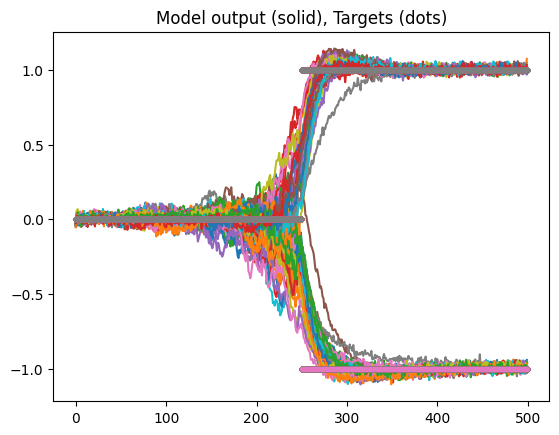

In [67]:
# simple plot the output of last batch (last group of trials)
# to visualize model performance
plt.plot(np.squeeze(outputs.cpu().detach()))
plt.plot(np.squeeze(targets.cpu().detach()),'.')
plt.title('Model output (solid), Targets (dots)')
plt.show()    

### Look at named model parameters to see current values of weights and biases and to see if they are trainable (requires_grad = True/False)

In [68]:
for p in net.named_parameters():
    print(p)

('recurrent_layer.inp_layer.weight', Parameter containing:
tensor([[ 7.9534e-01,  1.2440e+00,  4.1259e-01, -1.4827e+00],
        [-2.1520e+00, -2.1103e-01, -1.0152e+00, -5.5606e-01],
        [-8.8822e-01,  1.2762e+00,  9.0921e-01, -5.4217e-01],
        [-4.6155e-01, -1.3130e+00, -7.6562e-02, -4.5619e-02],
        [-1.2560e+00, -3.3690e-01, -4.1189e-01,  1.1166e+00],
        [ 1.0969e+00, -1.3658e+00,  3.9217e-01,  2.1592e-01],
        [-5.1049e-01,  5.5275e-01,  2.2680e-04,  7.9331e-01],
        [ 8.7656e-01,  2.1016e-01, -4.4237e-01,  1.1233e-01],
        [ 6.3564e-01, -1.1528e+00,  1.6655e-01,  1.1076e+00],
        [ 2.4469e-01, -6.7152e-01,  2.6642e-01,  2.9833e-01],
        [ 2.0273e-01,  7.5456e-01, -8.8608e-01, -9.7300e-01],
        [ 5.8601e-01, -1.1835e+00,  4.9733e-01,  1.6994e-01],
        [-7.1606e-01, -4.0304e-01, -9.5447e-01,  9.9102e-01],
        [ 5.1921e-01,  7.1141e-01, -6.0226e-01, -7.9294e-01],
        [ 4.3397e-01,  2.3785e+00,  1.2379e+00, -2.0283e-02],
        [-1